#Final Advanced Project
#Cycle Gan training notebook.
Adi Cohen (ID. 315674101), 
Lital Porat ID. 206571846), 
Batel Idan (ID. 316330489), 
Shir Lavi ID. 315243394

# Imports

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.11.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load in the data


In [ ]:
data,data_info = tfds.load('cycle_gan/monet2photo', download=True, with_info=True, shuffle_files=True)

In [ ]:
def imresize(image):
    image = tf.image.resize(image['image'], (256,256))
    image = tf.cast(image, tf.float32)
    image = (image / 255)
    return image


In [ ]:
train_monet, train_photos, test_monet, test_photos= data['trainA'], data['trainB'], data['testA'], data['testB']
train_monet=train_monet.map(imresize).shuffle(64).batch(1)
train_photos=train_photos.map(imresize).shuffle(64).batch(1)

In [ ]:
example_monet = next(iter(train_monet)).numpy()
example_photo = next(iter(train_photos)).numpy()
# print(example_photo)

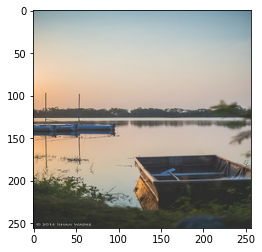

In [ ]:

generate_image = tf.Variable(next(iter(train_photos)))

plt.imshow(generate_image[0].numpy())

# single example

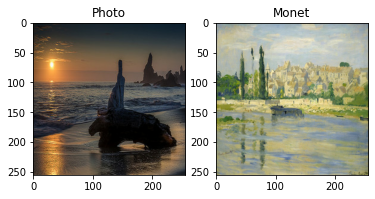

In [ ]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0])

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0])

In [ ]:
def graphFunc(history):
  plt.plot(history.history['monet_gen_loss'])
  plt.plot(history.history['monet_disc_loss'])
  plt.plot(history.history['photo_gen_loss'])
  plt.plot(history.history['photo_disc_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['monet', 'photos'], loc='upper left')
  plt.show()
 

# Base model

# Build the generator


In [ ]:
# function that creates a downsample layer for CNN
# The purpose of downsampling is to decrease the cost of the model by reducing the number of parameters.
# "filters": the number of filters or feature maps in the layer
# "size": the size of the convolutional kernel or filter
# "apply_instancenorm": a boolean indicating whether to apply instance normalization to the output of the convolutional layer
# Inside the function, a sequential model is created, includes a convolutional layer.
# The padding of the convolutional layer is set to 'same', which means the output feature maps have the same spatial dimensions as the input feature maps.
# The kernel_initializer parameter is set to a normal distribution with mean 0 and standard deviation 0.02, which initializes the weights of the layer.
# The use_bias parameter is set to False, which means the layer does not have a bias term.
# If apply_instancenorm is True, it adds an instance normalization layer, which is a normalization technique that normalizes the activations of each feature map separately across the spatial dimensions.
# LeakyReLU activation function is added to the output of the normalization layer, which allows for negative values in the feature maps.
# The output is the sequential model containing the downsample layer.

OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [ ]:
# function that creates an upsample layer for CNN
# The purpose of upsampling is to increase the resolution of the feature maps, while also extracting higher-level features from the input.
# If apply_dropout is True, the function adds a dropout layer. Dropout randomly sets a fraction of the input units to zero during training, which can help prevent overfitting.
# Finally, a ReLU activation function is added to the output of the dropout layer, which sets negative values in the feature maps to zero.
# ReLU is commonly used as the default activation function for most neural networks because of its simplicity and effectiveness.
# ReLU sets all negative values in the input to zero and leaves positive values unchanged.
# LeakyReLU is a variant of ReLU that prevents "dying ReLU" problem, which can occur when a large number of neurons have output values of zero,
# The output of the function is the sequential model containing the upsample layer.

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [ ]:
# The generator takes a random noise vector as input and generates a new image, with the goal of creating realistic images that could be mistaken for real images.
# The generator consists of two parts: a down-sampling (encoder) part, and an up-sampling (decoder) part.
# The purpose of the skip is to allow the up-sampling layers to directly access the corresponding feature maps from the down-sampling layers at the same spatial resolution.
# This helps to preserve fine-grained details in the generated image that may have been lost during down-sampling.

def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [ ]:
# descrimnator receptive field 60*60
# The discriminator model learns to classify whether an input image is real or fake by outputting a single scalar value 
# we added three extra convolutional layers with filter size 3x3 and stride 1, and adjusted the final padding and output dimensions
# A 2D zero-padding layer is applied to increase the spatial resolution of the feature maps.

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 3, strides=1, # changed filter size from 4 to 3
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 32, 32, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 34, 34, 512)
    conv2 = layers.Conv2D(512, 3, strides=1, # added an extra convolutional layer
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad2) # (bs, 32, 32, 512)
    
    norm2 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv2)

    leaky_relu2 = layers.LeakyReLU()(norm2)

    zero_pad3 = layers.ZeroPadding2D()(leaky_relu2) # (bs, 34, 34, 512)
    conv3 = layers.Conv2D(512, 3, strides=1, # added an extra convolutional layer
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad3) # (bs, 32, 32, 512)
    
    norm3 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv3)

    leaky_relu3 = layers.LeakyReLU()(norm3)

    zero_pad4 = layers.ZeroPadding2D()(leaky_relu3) # (bs, 34, 34, 512)
    conv4 = layers.Conv2D(512, 3, strides=1, # added an extra convolutional layer
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad4) # (bs, 32, 32, 512)
    
    norm4 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv4)

    leaky_relu4 = layers.LeakyReLU()(norm4)

    zero_pad5 = layers.ZeroPadding2D()(leaky_relu4) # (bs, 34, 34, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad5) # (bs, 31, 31, 1)

    return tf.keras.Model(inputs=inp, outputs=last)


In [ ]:
# strategy.scope used for distributed training across multiple devices (e.g., GPUs or TPUs).

with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

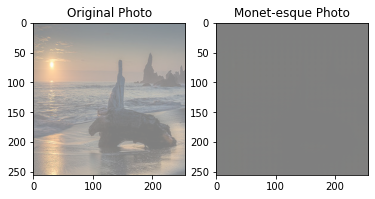

In [ ]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

**Build the CycleGAN model**

In [ ]:
# CycleGAN model using TensorFlow's Keras API
class CycleGan(keras.Model):
  # defines the architecture of the CycleGAN model by specifying the generators and discriminators for the two image domains
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
        #specifies the optimizers and loss functions for training the model
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
        #defines a single training step of the CycleGAN model
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet and back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo and back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

**Define loss functions**

In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [ ]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [ ]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

**Train the CycleGAN**


In [ ]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
 cycle_gan_model.built= True

In [ ]:
histbase = cycle_gan_model.fit(
    tf.data.Dataset.zip((train_monet, train_photos)),
    epochs=5
)

Epoch 1/5
1072/1072 [==============================] - 528s 493ms/step - monet_gen_loss: 2.6047 - photo_gen_loss: 2.6707 - monet_disc_loss: 0.6726 - photo_disc_loss: 0.6496
Epoch 2/5
1072/1072 [==============================] - 534s 498ms/step - monet_gen_loss: 2.2516 - photo_gen_loss: 2.2865 - monet_disc_loss: 0.6812 - photo_disc_loss: 0.6700
Epoch 3/5
1072/1072 [==============================] - 533s 498ms/step - monet_gen_loss: 2.2095 - photo_gen_loss: 2.2444 - monet_disc_loss: 0.6730 - photo_disc_loss: 0.6583
Epoch 4/5
1072/1072 [==============================] - 532s 496ms/step - monet_gen_loss: 2.1153 - photo_gen_loss: 2.0881 - monet_disc_loss: 0.6717 - photo_disc_loss: 0.6802
Epoch 5/5
1072/1072 [==============================] - 533s 497ms/step - monet_gen_loss: 2.0619 - photo_gen_loss: 2.0221 - monet_disc_loss: 0.6698 - photo_disc_loss: 0.6789


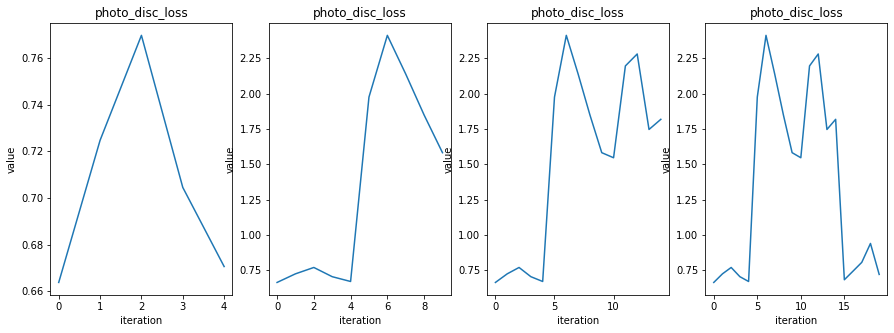

In [ ]:
from matplotlib import pyplot as plt
losses=[]

plt.figure(figsize = (15,5))

for i in range (5):
  loss = histbase.history['photo_disc_loss'][i][0]
  avg = np.mean(loss)
  losses.append(avg)
plt.subplot(1,4,1)
plt.title('photo_disc_loss')
plt.ylabel('value')
plt.xlabel('iteration')
plt.plot(losses)

for i in range (5):
  loss = histbase.history['photo_gen_loss'][i][0]
  avg = np.mean(loss)
  losses.append(avg)
plt.subplot(1,4,2)
plt.title('photo_disc_loss')
plt.ylabel('value')
plt.xlabel('iteration')
plt.plot(losses)

for i in range (5):
  loss = histbase.history['monet_gen_loss'][i][0]
  avg = np.mean(loss)
  losses.append(avg)
plt.subplot(1,4,3)
plt.title('photo_disc_loss')
plt.ylabel('value')
plt.xlabel('iteration')
plt.plot(losses)

for i in range (5):
  loss = histbase.history['monet_disc_loss'][i][0]
  avg = np.mean(loss)
  losses.append(avg)
plt.subplot(1,4,4)
plt.title('photo_disc_loss')
plt.ylabel('value')
plt.xlabel('iteration')
plt.plot(losses)


  # plt.plot(history.history['monet_gen_loss'])
  # plt.plot(history.history['monet_disc_loss'])



# plt.legend(['monet_disc_loss (histbase)', 'monet_disc_loss'], loc='upper right')
plt.show()


In [ ]:
cycle_gan_model.save_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/base.h5')
monet_generator.save_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/monet_generator.h5')
photo_generator.save_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/photo_generator.h5')
monet_discriminator.save_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/monet_discriminator.h5')
photo_discriminator.save_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/photo_discriminator.h5')


In [ ]:
loaded_monet_generator = Generator() # transforms photos to Monet-esque paintings
loaded_photo_generator = Generator() # transforms Monet paintings to be more like photos

loaded_monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
loaded_photo_discriminator = Discriminator()

loaded_monet_generator.load_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/monet_generator.h5')
loaded_photo_generator.load_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/photo_generator.h5')
loaded_monet_discriminator.load_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/monet_discriminator.h5')
loaded_photo_discriminator.load_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/photo_discriminator.h5')
# loaded_cycle=CycleGan(loaded_monet_generator, loaded_photo_generator, loaded_monet_discriminator, loaded_photo_discriminator )


/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


**Visualize our Monet-esque photos**

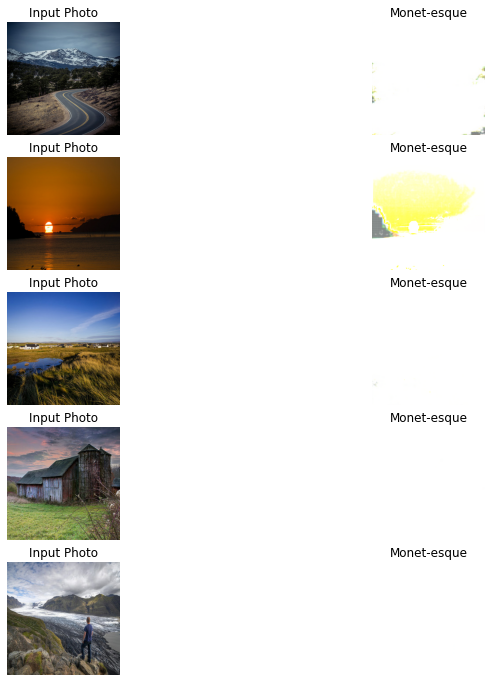

In [ ]:
photos = test_photo.take(5)
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photos):
    im = tf.expand_dims(img['image'], axis=0)
    prediction = loaded_monet_generator(im, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    # img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(im[0])
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# First Experiment

In [ ]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.03)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.03)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.03)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.03)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [ ]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(256, 4), # (bs, 16, 16, 256)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(256, 4), # (bs, 16, 16, 512)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.03)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [ ]:
# descrimnator receptive field 60*60: 
# we added three extra convolutional layers with filter size 3x3 and stride 1, and adjusted the final padding and output dimensions
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 3, strides=1, # changed filter size from 4 to 3
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 32, 32, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 34, 34, 512)
    conv2 = layers.Conv2D(512, 3, strides=1, # added an extra convolutional layer
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad2) # (bs, 32, 32, 512)
    
    norm2 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv2)

    leaky_relu2 = layers.LeakyReLU()(norm2)

    zero_pad3 = layers.ZeroPadding2D()(leaky_relu2) # (bs, 34, 34, 512)
    conv3 = layers.Conv2D(512, 3, strides=1, # added an extra convolutional layer
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad3) # (bs, 32, 32, 512)
    
    norm3 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv3)

    leaky_relu3 = layers.LeakyReLU()(norm3)

    zero_pad4 = layers.ZeroPadding2D()(leaky_relu3) # (bs, 34, 34, 512)
    conv4 = layers.Conv2D(512, 3, strides=1, # added an extra convolutional layer
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad4) # (bs, 32, 32, 512)
    
    norm4 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv4)

    leaky_relu4 = layers.LeakyReLU()(norm4)

    zero_pad5 = layers.ZeroPadding2D()(leaky_relu4) # (bs, 34, 34, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad5) # (bs, 31, 31, 1)

    return tf.keras.Model(inputs=inp, outputs=last)


In [ ]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


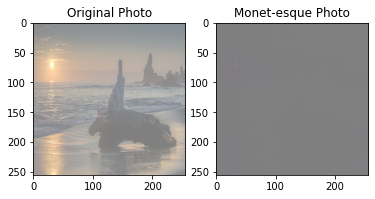

In [ ]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

**Build the CycleGan model**

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

**Define loss functions**

In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [ ]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [ ]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

**Train the CycleGan**

In [ ]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.9)
    photo_generator_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.9)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.9)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.9)

In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
cycle_gan_model.built = True

In [ ]:
histfirst = cycle_gan_model.fit(
    tf.data.Dataset.zip((train_monet, train_photos)),
    epochs=10
)

Epoch 1/10
1072/1072 [==============================] - 484s 425ms/step - monet_gen_loss: 2.7005 - photo_gen_loss: 2.8288 - monet_disc_loss: 0.6827 - photo_disc_loss: 0.6506
Epoch 2/10
1072/1072 [==============================] - 461s 430ms/step - monet_gen_loss: 2.1804 - photo_gen_loss: 2.3295 - monet_disc_loss: 0.6761 - photo_disc_loss: 0.6369
Epoch 3/10
1072/1072 [==============================] - 461s 430ms/step - monet_gen_loss: 2.0223 - photo_gen_loss: 2.2173 - monet_disc_loss: 0.6778 - photo_disc_loss: 0.6271
Epoch 4/10
1072/1072 [==============================] - 460s 429ms/step - monet_gen_loss: 1.9726 - photo_gen_loss: 2.0931 - monet_disc_loss: 0.6717 - photo_disc_loss: 0.6474
Epoch 5/10
1072/1072 [==============================] - 461s 430ms/step - monet_gen_loss: 1.8954 - photo_gen_loss: 1.9542 - monet_disc_loss: 0.6703 - photo_disc_loss: 0.6672
Epoch 6/10
1072/1072 [==============================] - 461s 430ms/step - monet_gen_loss: 1.8478 - photo_gen_loss: 1.9065 - monet_

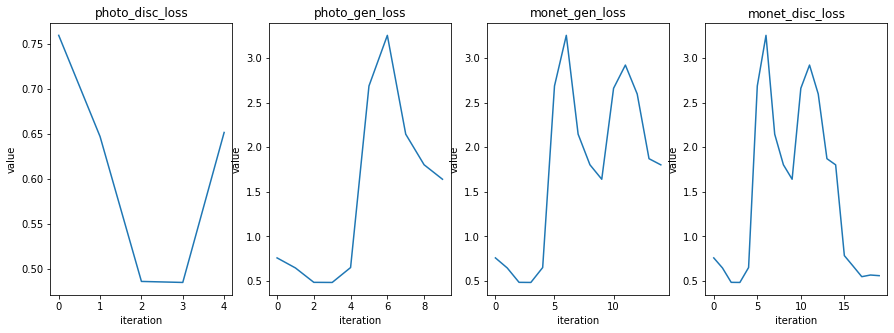

In [ ]:

from matplotlib import pyplot as plt
losses=[]

plt.figure(figsize = (15,5))

for i in range (5):
  loss = histfirst.history['photo_disc_loss'][i][0]
  avg = np.mean(loss)
  losses.append(avg)
plt.subplot(1,4,1)
plt.title('photo_disc_loss')
plt.ylabel('value')
plt.xlabel('iteration')
plt.plot(losses)

for i in range (5):
  loss = histfirst.history['photo_gen_loss'][i][0]
  avg = np.mean(loss)
  losses.append(avg)
plt.subplot(1,4,2)
plt.title('photo_gen_loss')
plt.ylabel('value')
plt.xlabel('iteration')
plt.plot(losses)

for i in range (5):
  loss = histfirst.history['monet_gen_loss'][i][0]
  avg = np.mean(loss)
  losses.append(avg)
plt.subplot(1,4,3)
plt.title('monet_gen_loss')
plt.ylabel('value')
plt.xlabel('iteration')
plt.plot(losses)

for i in range (5):
  loss = histfirst.history['monet_disc_loss'][i][0]
  avg = np.mean(loss)
  losses.append(avg)
plt.subplot(1,4,4)
plt.title('monet_disc_loss')
plt.ylabel('value')
plt.xlabel('iteration')
plt.plot(losses)


  # plt.plot(history.history['monet_gen_loss'])
  # plt.plot(history.history['monet_disc_loss'])



# plt.legend(['monet_disc_loss (histbase)', 'monet_disc_loss'], loc='upper right')
plt.show()

In [ ]:
cycle_gan_model.save_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/first.h5')
monet_generator.save_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/monet_generator1.h5')
photo_generator.save_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/photo_generator1.h5')
monet_discriminator.save_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/monet_discriminator1.h5')
photo_discriminator.save_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/photo_discriminator1.h5')

In [ ]:
loaded_monet_generator1 = Generator() # transforms photos to Monet-esque paintings
loaded_photo_generator1 = Generator() # transforms Monet paintings to be more like photos

loaded_monet_discriminator1 = Discriminator() # differentiates real Monet paintings and generated Monet paintings
loaded_photo_discriminator1 = Discriminator()

loaded_monet_generator1.load_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/monet_generator1.h5')
loaded_photo_generator1.load_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/photo_generator1.h5')
loaded_monet_discriminator1.load_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/monet_discriminator1.h5')
loaded_photo_discriminator1.load_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/photo_discriminator1.h5')
loaded_cycle1=CycleGan(loaded_monet_generator, loaded_photo_generator, loaded_monet_discriminator, loaded_photo_discriminator )

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


**Visualise our Monet-esque photos**

In [ ]:
test_photos= data['testB']

In [ ]:
test_photos=test_photos.map(imresize).batch(1)


In [ ]:
print(test_photos)

<BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>


<TakeDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>


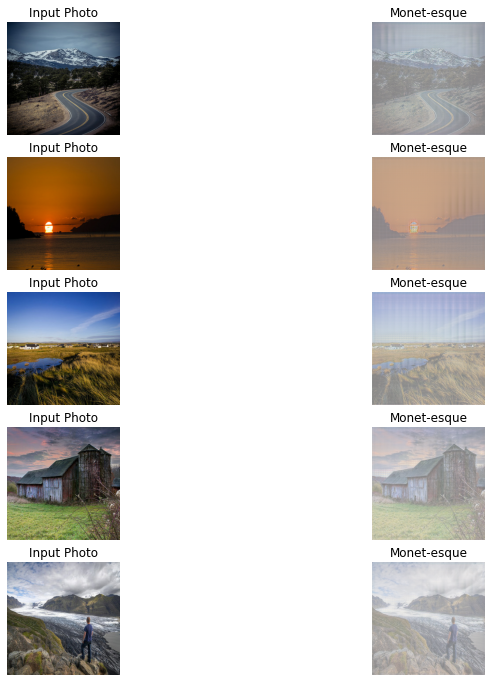

In [ ]:

photos = test_photos.take(5)
print(photos)
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photos):
    im = tf.expand_dims(img[0], axis=0)
    prediction = loaded_monet_generator1(im, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    # img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(im[0])
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Second Experiment

In [ ]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.01)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.01)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [ ]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.01)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [ ]:
# descrimnator receptive field 60*60: 
# we added three extra convolutional layers with filter size 3x3 and stride 1, and adjusted the final padding and output dimensions
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 3, strides=1, # changed filter size from 4 to 3
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 32, 32, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 34, 34, 512)
    conv2 = layers.Conv2D(512, 3, strides=1, # added an extra convolutional layer
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad2) # (bs, 32, 32, 512)
    
    norm2 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv2)

    leaky_relu2 = layers.LeakyReLU()(norm2)

    zero_pad3 = layers.ZeroPadding2D()(leaky_relu2) # (bs, 34, 34, 512)
    conv3 = layers.Conv2D(512, 3, strides=1, # added an extra convolutional layer
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad3) # (bs, 32, 32, 512)
    
    norm3 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv3)

    leaky_relu3 = layers.LeakyReLU()(norm3)

    zero_pad4 = layers.ZeroPadding2D()(leaky_relu3) # (bs, 34, 34, 512)
    conv4 = layers.Conv2D(512, 3, strides=1, # added an extra convolutional layer
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad4) # (bs, 32, 32, 512)
    
    norm4 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv4)

    leaky_relu4 = layers.LeakyReLU()(norm4)

    zero_pad5 = layers.ZeroPadding2D()(leaky_relu4) # (bs, 34, 34, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad5) # (bs, 31, 31, 1)

    return tf.keras.Model(inputs=inp, outputs=last)


In [ ]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

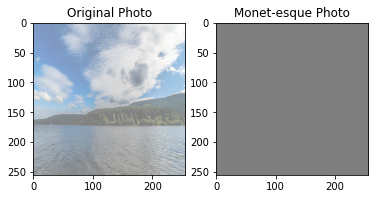

In [ ]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

**Build the CycleGan model**

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

**Define loss functions**

In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [ ]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [ ]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

**Train the CycleGan**

In [ ]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.5)

In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
cycle_gan_model.built =True

In [ ]:
histsec = cycle_gan_model.fit(
    tf.data.Dataset.zip((train_monet, train_photos)),
    epochs=15
)

Epoch 1/15
1072/1072 [==============================] - 584s 493ms/step - monet_gen_loss: 2.6072 - photo_gen_loss: 2.6858 - monet_disc_loss: 0.6822 - photo_disc_loss: 0.6647
Epoch 2/15
1072/1072 [==============================] - 534s 498ms/step - monet_gen_loss: 2.2231 - photo_gen_loss: 2.2735 - monet_disc_loss: 0.6829 - photo_disc_loss: 0.6722
Epoch 3/15
1072/1072 [==============================] - 534s 498ms/step - monet_gen_loss: 2.1833 - photo_gen_loss: 2.2355 - monet_disc_loss: 0.6809 - photo_disc_loss: 0.6670
Epoch 4/15
1072/1072 [==============================] - 534s 498ms/step - monet_gen_loss: 2.0913 - photo_gen_loss: 2.1263 - monet_disc_loss: 0.6735 - photo_disc_loss: 0.6603
Epoch 5/15
1072/1072 [==============================] - 534s 498ms/step - monet_gen_loss: 2.0383 - photo_gen_loss: 2.0571 - monet_disc_loss: 0.6675 - photo_disc_loss: 0.6571
Epoch 6/15
1072/1072 [==============================] - 531s 495ms/step - monet_gen_loss: 2.0159 - photo_gen_loss: 2.0575 - monet_

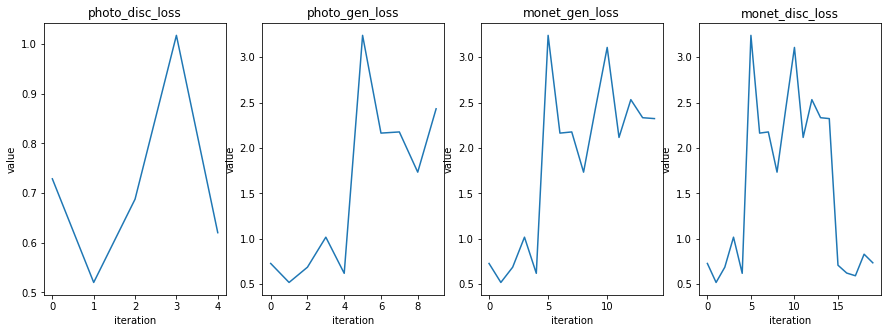

In [ ]:
from matplotlib import pyplot as plt
losses=[]

plt.figure(figsize = (15,5))

for i in range (5):
  loss = histsec.history['photo_disc_loss'][i][0]
  avg = np.mean(loss)
  losses.append(avg)
plt.subplot(1,4,1)
plt.title('photo_disc_loss')
plt.ylabel('value')
plt.xlabel('iteration')
plt.plot(losses)

for i in range (5):
  loss = histsec.history['photo_gen_loss'][i][0]
  avg = np.mean(loss)
  losses.append(avg)
plt.subplot(1,4,2)
plt.title('photo_gen_loss')
plt.ylabel('value')
plt.xlabel('iteration')
plt.plot(losses)

for i in range (5):
  loss = histsec.history['monet_gen_loss'][i][0]
  avg = np.mean(loss)
  losses.append(avg)
plt.subplot(1,4,3)
plt.title('monet_gen_loss')
plt.ylabel('value')
plt.xlabel('iteration')
plt.plot(losses)

for i in range (5):
  loss = histsec.history['monet_disc_loss'][i][0]
  avg = np.mean(loss)
  losses.append(avg)
plt.subplot(1,4,4)
plt.title('monet_disc_loss')
plt.ylabel('value')
plt.xlabel('iteration')
plt.plot(losses)


  # plt.plot(history.history['monet_gen_loss'])
  # plt.plot(history.history['monet_disc_loss'])



# plt.legend(['monet_disc_loss (histbase)', 'monet_disc_loss'], loc='upper right')
plt.show()

In [ ]:
cycle_gan_model.save_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/second.h5')
monet_generator.save_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/monet_generator2.h5')
photo_generator.save_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/photo_generator2.h5')
monet_discriminator.save_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/monet_discriminator2.h5')
photo_discriminator.save_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/photo_discriminator2.h5')

In [ ]:
loaded_monet_generator2 = Generator() # transforms photos to Monet-esque paintings

loaded_monet_generator2.load_weights('/content/drive/MyDrive/advFinalWeightsCYCLE/monet_generator2.h5')


**Visualise our Monet-esque photos**

<TakeDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>


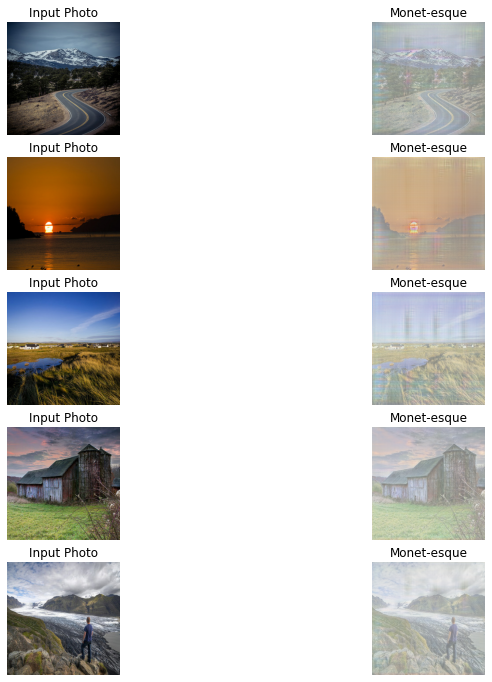

In [ ]:

photos = test_photos.take(5)
print(photos)
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photos):
    im = tf.expand_dims(img[0], axis=0)
    prediction = loaded_monet_generator2(im, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    # img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(im[0])
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()